In [1]:
# PyTorch之迁移学习

# 实际中，基本没有人会从零开始（随机初始化）训练一个完整的卷积网络，因为相对于网络，
# 很难得到一个足够大的数据集[网络很深, 需要足够大数据集]。
# 通常的做法是在一个很大的数据集上进行预训练得到卷积网络ConvNet, 然后将这个ConvNet的参数作为目标任务的初始化参数或者固定这些参数。

# 转移学习的两个主要场景：
# 微调Convnet：使用预训练的网络(如在imagenet 1000上训练而来的网络)来初始化自己的网络，而不是随机初始化。其他的训练步骤不变。
# 将Convnet看成固定的特征提取器:首先固定ConvNet除了最后的全连接层外的其他所有层。最后的全连接层被替换成一个新的随机初始化的层，
# 只有这个新的层会被训练[只有这层参数会在反向传播时更新]
# 下面是利用PyTorch进行迁移学习步骤，要解决的问题是训练一个模型来对蚂蚁和蜜蜂进行分类。

# liujia：我的理解和问题
# 1）微调convnet：这个怎么用预训练的网络来初始化自己的网络，如果网络结构不一样呢？是不是自己的网络的结构要类似于预训练的网络？
# 或者直接在上面加几层？
# 2）第二个感觉就是在上面加几层。。。。

In [2]:
# 下面是利用PyTorch进行迁移学习步骤，要解决的问题是训练一个模型来对蚂蚁和蜜蜂进行分类。

# 1 导入相关的包
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [31]:
# 2 加载数据

# 今天要解决的问题是训练一个模型来分类蚂蚁ants和蜜蜂bees。
# ants和bees各有约120张训练图片。每个类有75张验证图片。
# 从零开始在如此小的数据集上进行训练通常是很难泛化的。由于我们使用迁移学习，模型的泛化能力会相当好。 
# 该数据集是imagenet的一个非常小的子集。从此处下载数据，并将其解压缩到当前目录。

# liujia: 注意对训练集扩充(数据增强，比如随机crop，水平垂直翻转)，对验证集不用
# 训练集数据扩充和归一化
# 在验证集上仅需要归一化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), #随机裁剪一个area然后再resize
        transforms.RandomHorizontalFlip(), #随机水平翻转
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #这几个数怎么来的？
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), #为啥不直接resize到224呢？
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#liujia: 加载数据通常是定义目录，然后构造datasets，然后再构造dataloaders

data_dir = 'data/hymenoptera_data'
# image_datasets是一个dict，里面两个key：train/val，分别是构造好的torchvision.datasets.ImageFolder实例
# 同上节，ImageFolder以下面方式组织 /root/cat/xxx.jpg  /root/dog/xxx.jpg，即子目录名为分类名
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
# dataloaders同上也是一个dict,也是两个key:train/val, 对应加载上面的image_datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 无论batch_size是多大，len(image_datasets[x]获取到的都是数据集的样本个数
print('dataset_sizes:', dataset_sizes)

class_names = image_datasets['train'].classes # datasets的classes返回加载的所有分类的名字

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset_sizes: {'train': 244, 'val': 153}


classes: tensor([1, 1, 0, 1])
inputs shape: torch.Size([4, 3, 224, 224])
out shape: torch.Size([3, 228, 906])


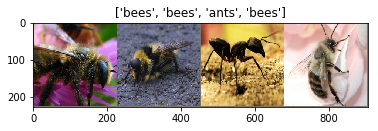

In [4]:
# 3 可视化部分图像数据

# 可视化部分训练图像，以便了解数据扩充。
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean #反归一化
    inp = np.clip(inp, 0, 1) #numpy的clip类似torch的clamp，将值限定在某一范围内，比如Relu将最小值限定为0
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# 获取一批训练数据
inputs, classes = next(iter(dataloaders['train'])) # 对上面的ImageFolder然后再DataLoader，返回的是图像数据和标注的分类(不是名字,而是012之类的数字)
print('classes:', classes)
print('inputs shape:', inputs.size()) #torch.Size([4, 3, 224, 224]), batch size是4， RGB3个通道，之前裁剪为224*224

# 批量制作网格
out = torchvision.utils.make_grid(inputs)
print('out shape:', out.size()) #torch.Size([3, 228, 906])，在width方向拼接。。。

imshow(out, title=[class_names[x] for x in classes])

In [28]:
# 4 训练模型

# 编写一个通用函数来训练模型。下面将说明： 
# * 调整学习速率 
# * 保存最好的模型

# 下面的参数scheduler是一个来自 torch.optim.lr_scheduler的学习速率调整类的对象(LR scheduler object)。
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # python中浅拷贝用“=”，而深拷贝用copy.deepcopy(obj)
    # 浅拷贝只是将原对象在内存中引用地址拷贝过来了。让新的对象指向这个地址。
    # 而深拷贝是将这个对象的所有内容遍历拷贝过来了，相当于跟原来没关系了，所以如果你这时候修改原来对象的值跟他没关系了，不会随之更改。
    best_model_wts = copy.deepcopy(model.state_dict()) 
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                # 这里必须把这个注释掉，会报warning。pytorch1.1.0之后，scheduler.step()必须在optimizer.step()后面调用
                # 否则会报warning
                # scheduler用于调整学习率，而optimizer用于更新擦拭
                # scheduler.step()通常在每个epoch调用一次，而optimizer.step()通常每个batch调用一次
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode  
            # liujia: 区别应该在于eval模式下，不用记录梯度了相当于with torch.no_grad():
            # 但是为什么下面还要显式的torch.set_grad_enable()...
            # 应该是那里grad是由torch统一处理的，而这里只是设置了model自己的模式。。。。
            # 那这里这两种模式下model到底区别在什么地方？还是仅仅是记录一下。。。。

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # 这种相当于适配了cpu和gpu两种环境。。。。
                labels = labels.to(device)

                # 零参数梯度
                optimizer.zero_grad() #liujia: 尽管已经说了几百次了，但还是不要忘了，每个batch的开头，都要清空梯度!!!

                # 前向
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    print('output:', outputs) 
                    print('output size:', outputs.size()) #batch_size是4，而类别个数是2，所以这里outputs输出维度(4,2)，第二维是对应类别的概率
                    # torch.max第二个参数是返回哪一个维度的最大值，这里传1，就是返回第二维的最大值
                    # 而第二维的最大值，就是类别概率最大的那个，以及对应的类别的index
                    _, preds = torch.max(outputs, 1) #max返回两个tensor，第一个是value，第二个是对应的index
                    print('preds:', preds)
                    print('preds size:', preds.size()) #outputs的size是(4,2),对第二维求最大，那么返回的size就是(4,1)
                    loss = criterion(outputs, labels)

                    # 后向+仅在训练阶段进行优化
                    if phase == 'train':
                        loss.backward() #反向传播
                        optimizer.step() #更新参数

                # 感觉torch.sum(preds == labels.data) 和 torch.sum(preds == labels) 没区别 
                # 数值上是一样的
                # 但.data返回原Tensor同样的数据，并舍弃了grad，grad_fn等额外反向图计算过程需保存的额外信息。
                # torch 0.4之后更推荐用.detach()代替.data
                # 参考https://blog.csdn.net/dss_dssssd/article/details/89526623
                # 简单的说就是，.data取出本体tensor后仍与原数据共享内存（从第一个代码段中可以看出），
                # 在使用in-place操作后，会修改原数据的值，而如果在反向传播过程中使用到原数据会导致计算错误，
                # 而使用.detach后，如果在反向传播过程中发现原数据被修改过会报错。更加安全
                print('labels:', labels) # 
                print('labels type:', type(labels))
                print('input size(0):', inputs.size(0))
                print('preds == labels:', preds == labels)
                print('preds == labels type:', type(preds == labels))
                print('preds == labels.data:', preds == labels.data)
                print('preds == labels.data type:', type(preds == labels.data))
                print('sum(preds == labels):', torch.sum(preds == labels))
                print('sum(preds == labels.data):', torch.sum(preds == labels.data))
                
                # 统计
                # inputs.size(0)应该是batch size，乘以batch size得到这个batch的loss，loss不确定是不是平均后的....
                running_loss += loss.item() * inputs.size(0) 
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            # 得到所有评估样本上的平均loss
            epoch_loss = running_loss / dataset_sizes[phase]
            # 得到所有评估样本上的平均预测正确率
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 深度复制mo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

In [29]:
# 5 可视化模型的预测结果
# 一个通用的展示少量预测图片的函数
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

aaaa
Epoch 0/0
----------
output: tensor([[ 0.7704, -0.4828],
        [ 0.2697, -0.3219],
        [ 0.0230,  0.2127],
        [ 0.3881, -0.8464]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([0, 0, 1, 0])
preds size: torch.Size([4])
labels: tensor([1, 1, 0, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([False, False, False, False])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([False, False, False, False])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(0)
sum(preds == labels.data): tensor(0)
output: tensor([[ 0.1084, -0.4340],
        [ 0.1221,  0.5649],
        [ 0.3633, -1.0097],
        [ 0.1054, -0.1021]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([0, 1, 0, 0])
preds size: torch.Size([4])
labels: tensor([0, 0, 0, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([ True, False,  True, False])
preds == la

output: tensor([[ 0.0945,  0.5197],
        [ 0.3876, -0.4011],
        [-0.8888,  1.1152],
        [-1.1245,  0.1257]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 0, 1, 1])
preds size: torch.Size([4])
labels: tensor([0, 0, 1, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([False,  True,  True, False])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([False,  True,  True, False])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(2)
sum(preds == labels.data): tensor(2)
output: tensor([[-1.3417,  1.0253],
        [-0.5334,  0.9470],
        [-0.0614, -0.3364],
        [ 0.6273, -0.3261]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 1, 0, 0])
preds size: torch.Size([4])
labels: tensor([1, 1, 0, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tenso

output: tensor([[-0.0481, -0.1898],
        [ 1.0343, -0.9493],
        [ 1.1183, -1.3238],
        [-1.8975,  2.4468]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([0, 0, 0, 1])
preds size: torch.Size([4])
labels: tensor([0, 0, 0, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([True, True, True, True])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(4)
sum(preds == labels.data): tensor(4)
output: tensor([[-0.7150,  1.1245],
        [ 0.9714, -0.4232],
        [-0.9232,  0.1485],
        [-0.3895,  0.1571]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 0, 1, 1])
preds size: torch.Size([4])
labels: tensor([1, 0, 0, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([ True,  True, False, False])
preds == labels type: <class 'torch.Tensor'>


output: tensor([[-1.8263,  1.7787],
        [ 1.2861, -0.9472],
        [ 0.7428, -1.1378],
        [ 0.6001, -0.4071]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 0, 0, 0])
preds size: torch.Size([4])
labels: tensor([1, 0, 0, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([True, True, True, True])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(4)
sum(preds == labels.data): tensor(4)
output: tensor([[-0.8165,  0.1974],
        [ 0.2060, -0.5262],
        [ 0.7631,  0.8684],
        [ 0.5024, -1.3101]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 0, 1, 0])
preds size: torch.Size([4])
labels: tensor([1, 1, 1, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([ True, False,  True,  True])
preds == labels type: <class 'torch.Tensor'>


output: tensor([[ 0.7576, -0.2081],
        [ 0.4344, -0.5943],
        [-1.5634,  0.8875],
        [-3.2339,  3.5538]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([0, 0, 1, 1])
preds size: torch.Size([4])
labels: tensor([0, 0, 1, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([True, True, True, True])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(4)
sum(preds == labels.data): tensor(4)
output: tensor([[-0.1074,  0.6894],
        [-1.0598,  0.9804],
        [-3.8580,  3.5921],
        [ 0.0592, -0.1591]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 1, 1, 0])
preds size: torch.Size([4])
labels: tensor([0, 0, 1, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([False, False,  True,  True])
preds == labels type: <class 'torch.Tensor'>


output: tensor([[-0.0427,  0.7685],
        [-3.3216,  2.6318],
        [ 0.1750, -0.1220],
        [-2.9523,  3.2743]])
output size: torch.Size([4, 2])
preds: tensor([1, 1, 0, 1])
preds size: torch.Size([4])
labels: tensor([0, 1, 0, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([False,  True,  True,  True])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([False,  True,  True,  True])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(3)
sum(preds == labels.data): tensor(3)
output: tensor([[-0.7847,  1.7850],
        [-0.0432,  0.2849],
        [ 0.7072, -0.5116],
        [-3.4558,  4.0781]])
output size: torch.Size([4, 2])
preds: tensor([1, 1, 0, 1])
preds size: torch.Size([4])
labels: tensor([1, 0, 0, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([ True, False,  True,  True])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([ True, False

output: tensor([[-0.2413, -0.5966],
        [-1.6209,  1.7507],
        [-3.9068,  4.5234],
        [-1.3774,  0.5572]])
output size: torch.Size([4, 2])
preds: tensor([0, 1, 1, 1])
preds size: torch.Size([4])
labels: tensor([0, 1, 1, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([True, True, True, True])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(4)
sum(preds == labels.data): tensor(4)
output: tensor([[-3.8000,  3.1834],
        [-0.9126,  1.6023],
        [-4.5555,  4.7473],
        [ 1.6250, -1.5131]])
output size: torch.Size([4, 2])
preds: tensor([1, 1, 1, 0])
preds size: torch.Size([4])
labels: tensor([1, 1, 1, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([True, True, True, True])

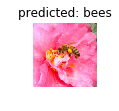

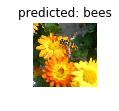

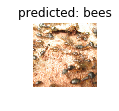

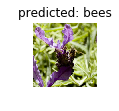

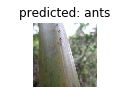

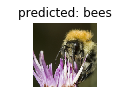

In [30]:
# 场景1：微调ConvNet
# liujia: 以预训练模型为初始参数，训练所有层的finetune

# 加载预训练模型并重置最终完全连接的图层，fc是最后的full connected layer
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features #最后的全连接层的输入维度
model_ft.fc = nn.Linear(num_ftrs, 2) # 将最后一层改为对应维度(原来的输入和维度为2的输出，因为我们就2个类别....)

model_ft = model_ft.to(device) #适配GPU环境

criterion = nn.CrossEntropyLoss()

# 观察所有参数都正在优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个epochs衰减LR通过设置gamma=0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 训练和评估模型
#（1）训练模型 该过程在CPU上需要大约15-25分钟，但是在GPU上，它只需不到一分钟
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

# 输出如下：
'''
Epoch 0/24
----------
train Loss: 0.7032 Acc: 0.6025
val Loss: 0.1698 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.6411 Acc: 0.7787
val Loss: 0.1981 Acc: 0.9281
·
·
·
Epoch 24/24
----------
train Loss: 0.2812 Acc: 0.8730
val Loss: 0.2647 Acc: 0.9150

Training complete in 1m 7s
Best val Acc: 0.941176
'''

# 2）模型评估效果可视化
visualize_model(model_ft)

In [33]:
# 场景2：ConvNet作为固定特征提取器
# liujia: 这种就是只训练最后的全连接层，这样训练的参数少，速度必然快。。。。
# 我这台MacbookPro测试，只训练一个epoch，第一种需要1m20s,这种是35s,快了至少一倍....

# 在这里需要冻结除最后一层之外的所有网络。通过设置requires_grad == False来冻结参数，
# 这样在反向传播backward()的时候他们的梯度就不会被计算。

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/0
----------
output: tensor([[-0.5427,  0.5189],
        [-0.3552,  0.1978],
        [-0.1017,  0.0748],
        [-0.5770,  0.2863]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 1, 1, 1])
preds size: torch.Size([4])
labels: tensor([1, 0, 0, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([ True, False, False, False])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([ True, False, False, False])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(1)
sum(preds == labels.data): tensor(1)
output: tensor([[-0.6937, -0.4571],
        [-0.1774,  0.9108],
        [-0.0479, -0.2465],
        [-0.0508,  0.3501]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 1, 0, 1])
preds size: torch.Size([4])
labels: tensor([1, 0, 1, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([ True, False, False,  True])
preds == labels 

output: tensor([[ 0.7807, -0.5893],
        [-0.1334, -0.6526],
        [-0.2290,  0.2436],
        [ 0.1256,  0.0088]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([0, 0, 1, 0])
preds size: torch.Size([4])
labels: tensor([0, 0, 1, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([ True,  True,  True, False])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([ True,  True,  True, False])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(3)
sum(preds == labels.data): tensor(3)
output: tensor([[-0.2127, -0.0029],
        [ 0.1554, -0.2904],
        [ 0.7470, -0.5141],
        [-0.5425, -0.0717]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 0, 0, 1])
preds size: torch.Size([4])
labels: tensor([0, 1, 0, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([False, False,  True,  True])
preds == labels type: <class 'torch.T

output: tensor([[-1.3761,  0.3190],
        [ 0.5793,  0.2943],
        [ 0.6336, -0.4548],
        [ 0.0817, -0.3624]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 0, 0, 0])
preds size: torch.Size([4])
labels: tensor([1, 1, 0, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([ True, False,  True, False])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([ True, False,  True, False])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(2)
sum(preds == labels.data): tensor(2)
output: tensor([[-1.0372,  0.7840],
        [ 0.7439, -0.5384],
        [ 0.8333, -0.7048],
        [-1.2346,  0.7240]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 0, 0, 1])
preds size: torch.Size([4])
labels: tensor([1, 0, 0, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tenso

output: tensor([[-0.7515,  0.2253],
        [ 0.1506,  0.4311],
        [ 0.5824, -0.8737],
        [-0.5592,  0.5197]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 1, 0, 1])
preds size: torch.Size([4])
labels: tensor([1, 1, 0, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([True, True, True, True])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(4)
sum(preds == labels.data): tensor(4)
output: tensor([[ 0.6324, -0.0726],
        [-2.6531,  2.3781],
        [ 0.2429, -0.3186],
        [-0.1222, -0.4570]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([0, 1, 0, 0])
preds size: torch.Size([4])
labels: tensor([0, 1, 0, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tensor'>
pred

output: tensor([[-0.2891,  0.2614],
        [ 2.2439, -1.4824],
        [ 2.5956, -3.4720],
        [ 0.5307, -0.9274]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([1, 0, 0, 0])
preds size: torch.Size([4])
labels: tensor([1, 1, 0, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([ True, False,  True, False])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([ True, False,  True, False])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(2)
sum(preds == labels.data): tensor(2)
output: tensor([[ 0.8755, -0.8040],
        [ 0.7962, -1.3819],
        [ 1.3004, -1.5946],
        [ 2.5912, -2.2105]], grad_fn=<AddmmBackward>)
output size: torch.Size([4, 2])
preds: tensor([0, 0, 0, 0])
preds size: torch.Size([4])
labels: tensor([0, 0, 0, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tenso

output: tensor([[-1.5032,  0.7322],
        [ 1.6057, -1.9810],
        [ 2.2391, -1.9489],
        [ 2.8833, -3.1029]])
output size: torch.Size([4, 2])
preds: tensor([1, 0, 0, 0])
preds size: torch.Size([4])
labels: tensor([1, 0, 0, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([True, True, True, True])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(4)
sum(preds == labels.data): tensor(4)
output: tensor([[ 3.4083, -4.0066],
        [-1.5638,  0.9509],
        [-1.2625,  1.6261],
        [-0.6818,  0.5123]])
output size: torch.Size([4, 2])
preds: tensor([0, 1, 1, 1])
preds size: torch.Size([4])
labels: tensor([0, 1, 1, 1])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([True, True, True, True])

output: tensor([[-0.5355, -0.3811],
        [ 2.3740, -2.0579],
        [ 0.0084, -0.1626],
        [ 2.1543, -2.1388]])
output size: torch.Size([4, 2])
preds: tensor([1, 0, 0, 0])
preds size: torch.Size([4])
labels: tensor([1, 0, 1, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([ True,  True, False,  True])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([ True,  True, False,  True])
preds == labels.data type: <class 'torch.Tensor'>
sum(preds == labels): tensor(3)
sum(preds == labels.data): tensor(3)
output: tensor([[ 2.7521, -2.2599],
        [ 1.4219, -1.5449],
        [ 3.2352, -2.0353],
        [ 1.8977, -1.9107]])
output size: torch.Size([4, 2])
preds: tensor([0, 0, 0, 0])
preds size: torch.Size([4])
labels: tensor([0, 0, 0, 0])
labels type: <class 'torch.Tensor'>
input size(0): 4
preds == labels: tensor([True, True, True, True])
preds == labels type: <class 'torch.Tensor'>
preds == labels.data: tensor([True, True, True

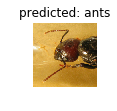

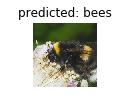

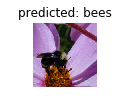

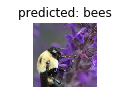

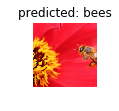

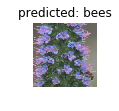

In [34]:
# 训练和评估

# 1）训练模型 在CPU上，与前一个场景相比，这将花费大约一半的时间，因为不需要为大多数网络计算梯度。但需要计算转发。
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=1)

# 输出
'''
Epoch 0/24
----------
train Loss: 0.6400 Acc: 0.6434
val Loss: 0.2539 Acc: 0.9085
·
·
·
Epoch 23/24
----------
train Loss: 0.2988 Acc: 0.8607
val Loss: 0.2151 Acc: 0.9412

Epoch 24/24
----------
train Loss: 0.3519 Acc: 0.8484
val Loss: 0.2045 Acc: 0.9412

Training complete in 0m 35s
Best val Acc: 0.954248
'''

# （2）模型评估效果可视化
visualize_model(model_conv)

plt.ioff()
plt.show()

